In [52]:
# Colab setup
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'LLM-Project')
os.chdir(GOOGLE_DRIVE_PATH)

In [28]:
! pip -q install bitsandbytes

# DriveLM

In [29]:
import os
from PIL import Image

nuscenes_path = 'DriveLM/data/nuscenes/samples/'

nuscenes = {}

for folder in os.listdir(nuscenes_path):
    folder_path = os.path.join(nuscenes_path, folder)
    if os.path.isdir(folder_path):
        nuscenes[folder] = {}
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            nuscenes[folder][img_name] = Image.open(img_path)


In [45]:
import json
from datasets import Dataset


class DriveLM:
    def __init__(self, json_path="DriveLM/data/QA_dataset_nus/v1_0_train_nus.json"):

        with open(json_path, 'r') as f:
            data = json.load(f)

        examples = []
        for scene_token, scene_data in data.items():
            scene_desc = scene_data.get('scene_description')
            for frame_token, frame_data in scene_data['key_frames'].items():
                image_paths = frame_data.get('image_paths', {})
                for task, qa_list in frame_data['QA'].items():
                    for qa in qa_list:
                        example = {
                            "scene_token": scene_token,
                            "frame_token": frame_token,
                            "scene_description": scene_desc,
                            "task": task,
                            "question": qa.get("Q"),
                            "answer": qa.get("A"),
                            "context": qa.get("C"),
                            "image_paths": image_paths,
                        }
                        examples.append(example)

        self.hf_dataset = Dataset.from_list(examples)

    def filter(self, function):
        self.hf_dataset = self.hf_dataset.filter(function)


    def __getitem__(self, idx):
      keys = ['scene_description', 'question', 'answer']
      sample = {key: self.hf_dataset[idx][key] for key in keys}

      sample['images'] = {}
      for image_type, image_path in self.hf_dataset[idx]['image_paths'].items():
          image_name = image_path.split('/')[-1]
          sample['images'][image_type] = nuscenes[image_type][image_name]
      return sample

    def __len__(self):
        return len(self.hf_dataset)


dataset = DriveLM()

In [46]:
len(dataset)

377983

In [47]:
import re


def contains_object(text):
    return re.search(r'<*>',text) != None

dataset.filter(lambda example: not contains_object(example['question']) and not contains_object(example['answer']))

Filter:   0%|          | 0/377983 [00:00<?, ? examples/s]

In [44]:
len(dataset)

132923

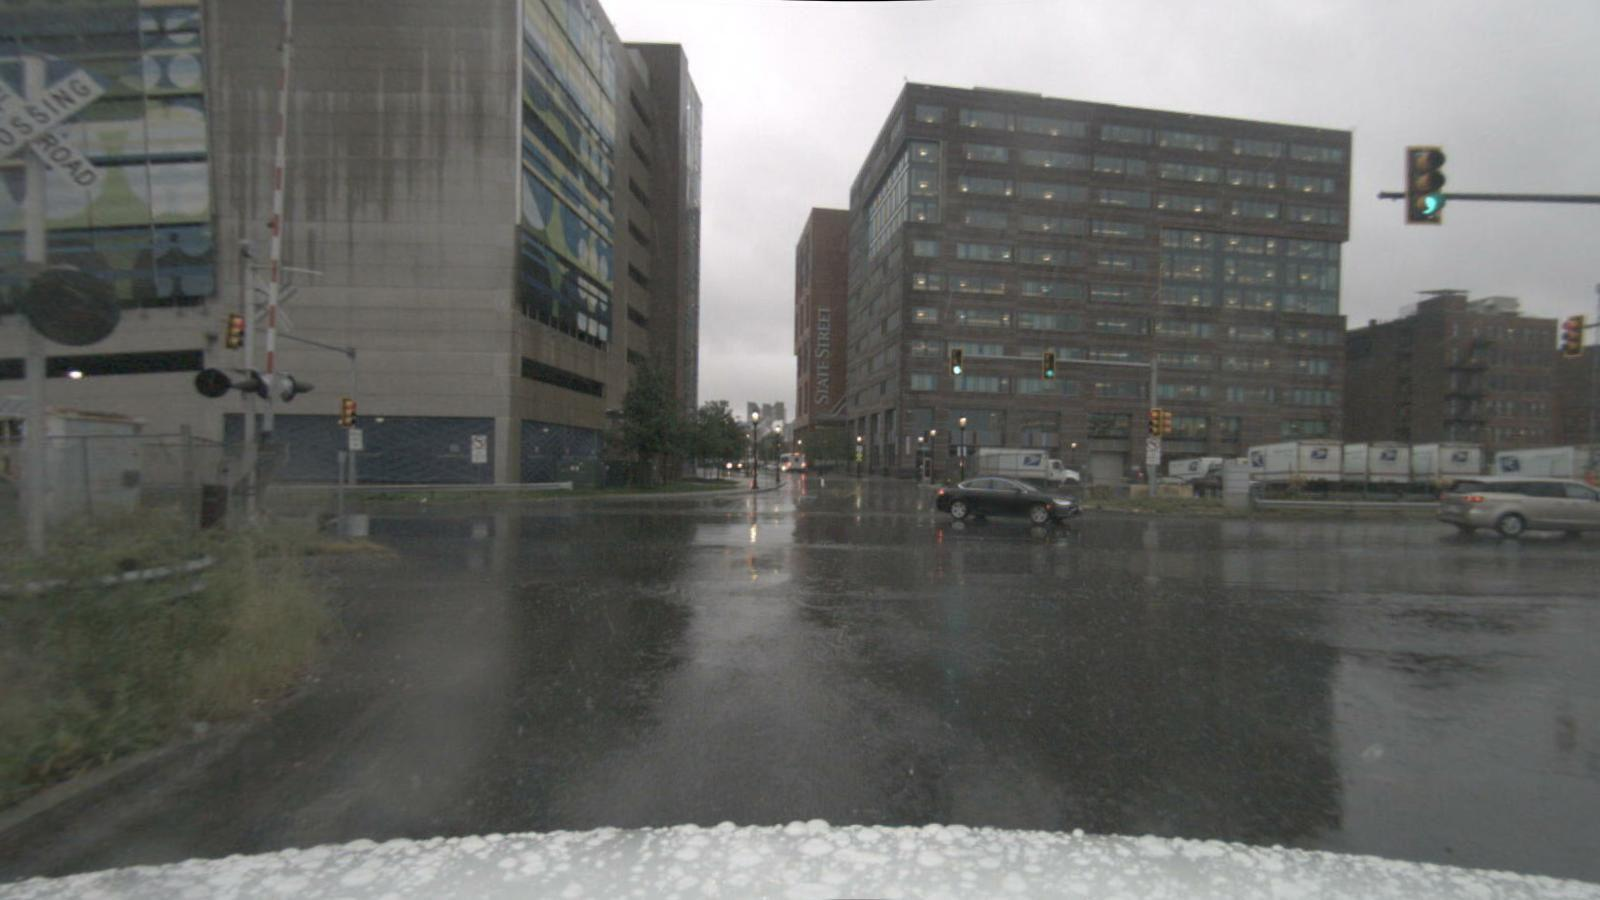

In [51]:
dataset[100]['images']['CAM_BACK']

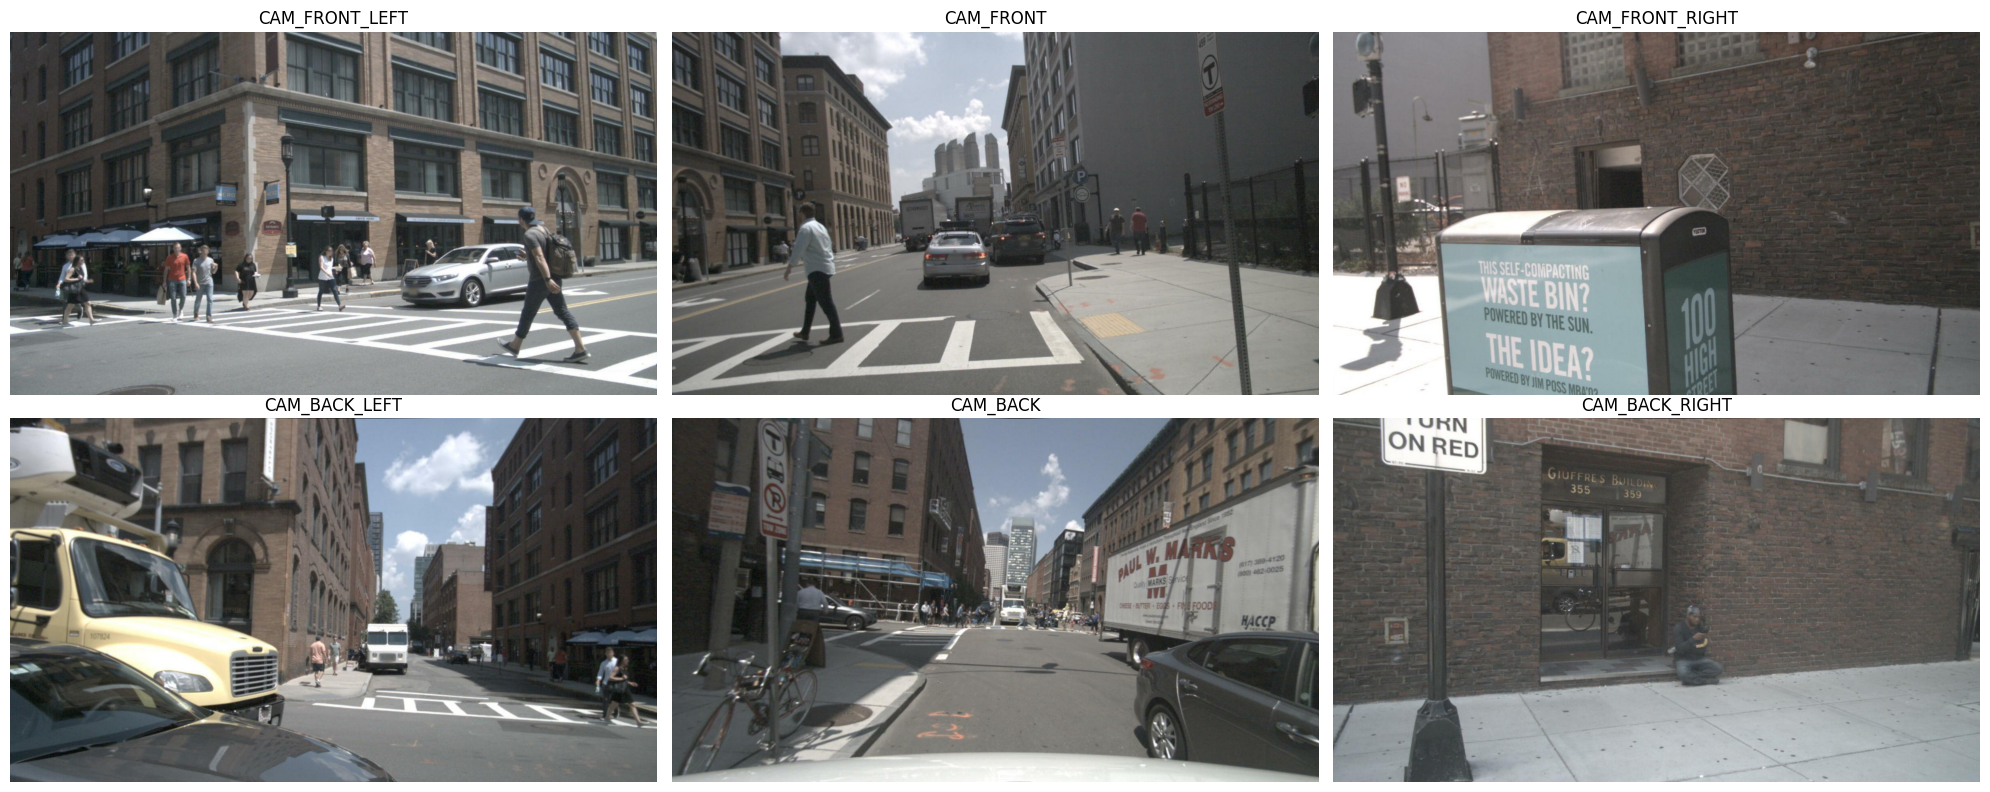

scene_description: The ego vehicle is parked on the right side of the current road.
question: Are there moving trailers to the front of the ego car?
answer: Yes.


In [49]:
import matplotlib.pyplot as plt

index = 510
sample = dataset[index]

def display_image(image, title):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

plt.figure(figsize=(20, 8))
cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
for i, camera in enumerate(cameras):
    plt.subplot(2, 3, i + 1)
    display_image(sample['images'][camera], camera)
plt.tight_layout()
plt.show()

for key, value in sample.items():
    if type(value) is str:
        print(f"{key}: {value}")

# Llava

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
import torch

model_id = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
!wget "https://i.postimg.cc/44hZvX9K/majestic-medieval-castle-stockcake.jpg" -O sample.png
castle_image = Image.open("sample.png")
# castle_image

In [ ]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg' -O cat.png
cat_image = Image.open("cat.png")
# cat_image

In [ ]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": cat_image},
            {"type": "image", "image": castle_image},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, torch.float16)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
processor.batch_decode(generate_ids, skip_special_tokens=True)

['USER:  \n \nWhat is shown in this image? ASSISTANT: The image shows a large, old castle with a stone wall and a cat walking around it. The castle is situated on a hill, and the cat is exploring the area.']

In [ ]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

sample = dataset[510]

cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
user_msg = []
for camera in cameras:
    user_msg.extend([
        {"type": "text", "text": camera},
        {"type": "image", "image": sample["images"][camera]}
    ])
user_msg.append({"type": "text", "text":sample["question"]})

conversation = [
    {
        "role": "user",
        "content": user_msg,
    },
]

sample2 = dataset[210]

cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
user_msg2 = []
for camera in cameras:
    user_msg2.extend([
        {"type": "text", "text": camera},
        {"type": "image", "image": sample2["images"][camera]}
    ])
user_msg2.append({"type": "text", "text":sample2["question"]})

conversation2 = [
    {
        "role": "user",
        "content": user_msg2,
    },
]

inputs = processor.apply_chat_template(
    [conversation, conversation2],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    padding=True,
).to(model.device, torch.float16)

# Generate
generate_ids = model.generate(**inputs, max_new_tokens=50)
print(processor.batch_decode(generate_ids, skip_special_tokens=True))

In [ ]:
processor.batch_decode(generate_ids, skip_special_tokens=True)[1]

'USER:  \n \n \n \n \n \nCAM_FRONT_LEFT CAM_FRONT CAM_FRONT_RIGHT CAM_BACK_LEFT CAM_BACK CAM_BACK_RIGHT What kind of traffic sign is <c3,CAM_FRONT,864.5,293.6>? ASSISTANT: The traffic sign is a stop sign.'

In [ ]:
processor.batch_decode(generate_ids, skip_special_tokens=True)[0]

'USER:  \n \n \n \n \n \nCAM_FRONT_LEFT CAM_FRONT CAM_FRONT_RIGHT CAM_BACK_LEFT CAM_BACK CAM_BACK_RIGHT In this scenario, what are safe actions to take for the ego vehicle? ASSISTANT: In this scenario, the ego vehicle is driving down a street with a building in the background. To ensure safety, the driver should maintain a safe distance from other vehicles, pedestrians, and any obstacles on the road. They should'

In [ ]:
print("ground truth:", sample2['answer'])

ground truth: Traffic light.


# Fine-tune

In [ ]:
from torch.utils.data import Dataset

class VLMQADataset(Dataset):
    def __init__(self, dataset: DriveLM):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

        user_msg = []
        for camera in cameras:
            user_msg.extend([
                {"type": "text", "text": camera},
                {"type": "image", "image": item["images"][camera]}
            ])
        user_msg.append({"type": "text", "text":item["question"]})

        conversation = [
            {
                "role": "user",
                "content": user_msg,
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": item["answer"]},
                ],
            }
        ]

        inputs = processor.apply_chat_template(
            conversation,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(torch.float16)

        labels = inputs['input_ids'].clone()
        # labels[:num_image_tokens] = -100  # Mask out image tokens

        inputs['labels'] = labels

        return inputs


In [ ]:
from peft import prepare_model_for_kbit_training

model2 = prepare_model_for_kbit_training(model)
del model

model2.gradient_checkpointing_enable()
model2.enable_input_require_grads()

In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import Trainer, TrainingArguments

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules="all-linear",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model2, peft_config)

In [ ]:
peft_model.print_trainable_parameters()

trainable params: 47,267,840 || all params: 7,110,694,912 || trainable%: 0.6647


In [ ]:
import torch
import gc


# del model2, processor, peft_model
torch.cuda.empty_cache()
gc.collect()


0

In [ ]:
from transformers import Trainer, TrainingArguments

train_dataset = VLMQADataset(dataset)

training_args = TrainingArguments(
    output_dir="./checkpoints",
    per_device_train_batch_size=1,
    num_train_epochs=1,
    learning_rate=2e-5,
    logging_steps=1,
    save_steps=200,
    bf16=True,
    report_to="none",
    label_names=["labels"],
    gradient_checkpointing=True,
)

def data_collator(features):
    return features[0]
    # Collate input_ids, attention_mask, labels, pixel_values, etc.
    # batch = {}
    # for key in features[0]:
        # if key == "pixel_values":
            # batch[key] = torch.concatenate([f[key] for f in features], dim=0)
        # else:
            # batch[key] = torch.stack([f[key] for f in features])
    # return batch

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.55 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.55 GiB is free. Process 229807 has 13.19 GiB memory in use. Of the allocated memory 11.62 GiB is allocated by PyTorch, and 1.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)